In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
import random
from IPython.display import clear_output
from visualize import render_points, render_transforms
from ifs import iterate
from markov import weighted_random_chooser, determinant_probabilities
from catalogue.leaves import FERN2D
from objective import hutchinson
from geomloss import SamplesLoss

In [3]:
target_points = iterate(weighted_random_chooser(FERN2D), num_iters=400)
print(target_points)

[[ 0.          0.        ]
 [ 0.          1.6       ]
 [ 0.064       2.96      ]
 [ 0.8192      1.16704   ]
 [ 0.7430016   2.559216  ]
 [ 0.73392     3.74561354]
 [ 0.77365654  4.75441471]
 [ 0.84778465  5.61030624]
 [ 0.9450292   6.33484892]
 [ 1.63200332  2.20607133]
 [ 1.47544567  3.4098805 ]
 [ 1.39052404  4.4393806 ]
 [-0.87613415  2.89648426]
 [-0.62885465  4.09705699]
 [-0.37064418  5.10765263]
 [-0.11074145  5.9563305 ]
 [ 0.14412299  6.66731058]
 [ 1.84522851  2.07762652]
 [ 0.30495115  1.41838978]
 [ 0.31594407  2.79343327]
 [ 0.38028979  3.96178051]
 [ 0.48171754  4.95230184]
 [ 0.60755198  5.79018787]
 [ 0.7480267   6.49735761]
 [ 0.895717    7.0928329 ]
 [ 1.04507277  7.59307928]
 [ 1.19203502  8.01231448]
 [ 1.33372235  8.36278591]
 [ 1.46817543  8.65501913]
 [ 1.59414988  8.89803924]
 [ 1.71094897  9.09956736]
 [ 1.81828932  9.2661943 ]
 [ 1.91619369  9.40353358]
 [ 2.34556035  3.19505842]
 [ 2.12152863  4.22197724]
 [ 1.97217843  5.10381951]
 [ 1.88050444  5.85935945]
 

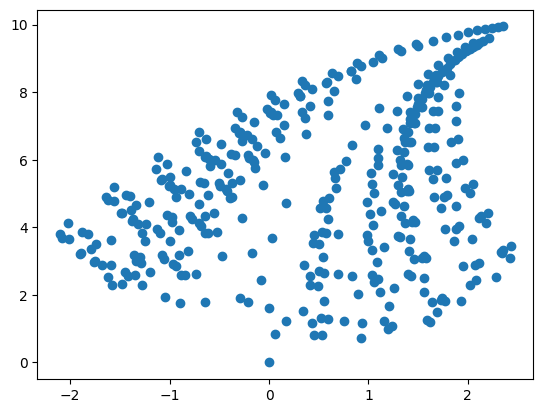

In [66]:
plt.clf()
plt.scatter(target_points.T[0], target_points.T[1])
plt.show()

In [51]:

def random_affine():
    return torch.cat([
        torch.rand(2) * torch.tensor([np.pi * 2, 1]),
        torch.randn(2) / 2
    ]) # rotate, scale, dx, dy


def affine_to_matrix(a):
    out = torch.zeros(3, 3)
    out[0, 0] = a[1] * a[0].cos()
    out[0, 1] = a[1] * -a[0].sin()
    out[1, 0] = a[1] * a[0].sin()
    out[1, 1] = a[1] * a[0].cos()
    out[0, 2] = a[2]
    out[1, 2] = a[3]
    out[2, 2] = 1.
    return out

def chamfer(A, B): # A = target, B = trace
    assert A.shape[1] == 2
    assert B.shape[1] == 2
    
    dists = ((A.unsqueeze(0) - B.unsqueeze(1)) ** 2).sum(dim=2)
    
    mins_a = torch.min(dists, dim=0).values
    mins_b = torch.min(dists, dim=1).values
    return mins_a.mean() + mins_b.mean()

sinkhorn_distance = SamplesLoss(loss='sinkhorn', p=1, blur=0.05, backend='tensorized', scaling = 0.5, verbose=True)

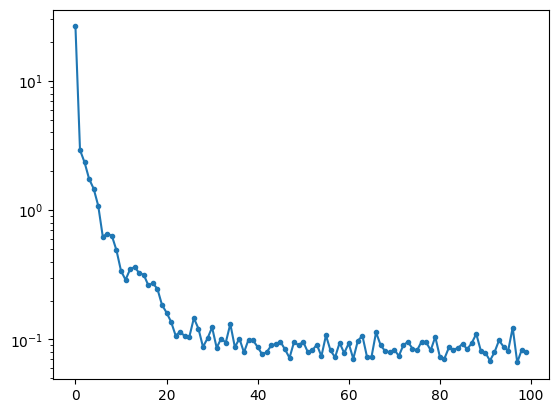

In [66]:
N = 5
F_ = [random_affine() for i in range(N)]

for f in F_:
    f.requires_grad_()
o = torch.optim.Adam(F_, lr=0.02)


losses = []

sample_target = torch.tensor(target_points, dtype=torch.float)
for step in range(10_000):
    o.zero_grad()
    
    v = torch.tensor([0., 0., 1.])
    trace = []
    
    F = [affine_to_matrix(a) for a in F_]
    fate = [random.randrange(len(F)) for _ in range(400)]
    for f in fate:
        v = torch.matmul(F[f], v)
        trace.append(v)

    trace = torch.stack(trace)[:, :2]
    
    loss = chamfer(sample_target, trace)
    loss.backward()
    o.step()
    
    if step % 100 == 0:
        losses.append(loss.detach().item())
        
        clear_output(wait=True)
        """trace_ = trace.detach().numpy()
        plt.title('iter = %d and loss = %f' % (step, loss.detach().item()))
        plt.axis('equal')
        plt.imshow(~img, extent=(-0.5, 0.5, -0.5, 0.5))
        plt.plot(trace_[:, 0], trace_[:, 1], 'k+')
        plt.savefig('out/%010d.jpg' % step)
        plt.show()"""
        
plt.figure()
plt.plot(losses, '.-')
plt.yscale('log')
plt.show()

In [67]:
F = np.array([affine_to_matrix(a).detach() for a in F_])
print(F)

[[[-6.54611969e-03 -1.21290344e-04  5.85975219e-03]
  [ 1.21290344e-04 -6.54611969e-03  8.18128698e-03]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 4.98865992e-01  6.25830516e-02  6.73844755e-01]
  [-6.25830516e-02  4.98865992e-01  5.31452608e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 2.91439891e-01  2.52354294e-01  9.66759771e-03]
  [-2.52354294e-01  2.91439891e-01  1.06784213e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.07017092e-01 -4.33130115e-01  1.17148733e+00]
  [ 4.33130115e-01  1.07017092e-01  2.69880199e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 2.66171902e-01 -4.15323436e-01  2.29603529e+00]
  [ 4.15323436e-01  2.66171902e-01  3.23363113e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]


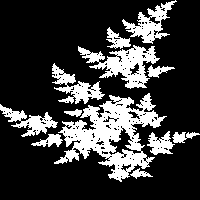

In [71]:
pred_points = iterate(weighted_random_chooser(F), 100_000)
render_points(pred_points)

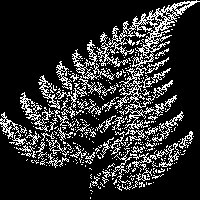

In [28]:
render_points(iterate(weighted_random_chooser(FERN2D)))

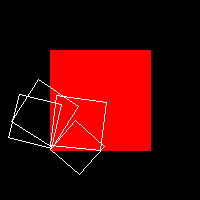

In [69]:
render_transforms(F)

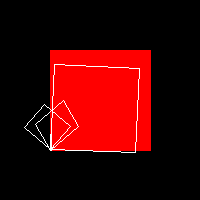

In [49]:
render_transforms(FERN2D)

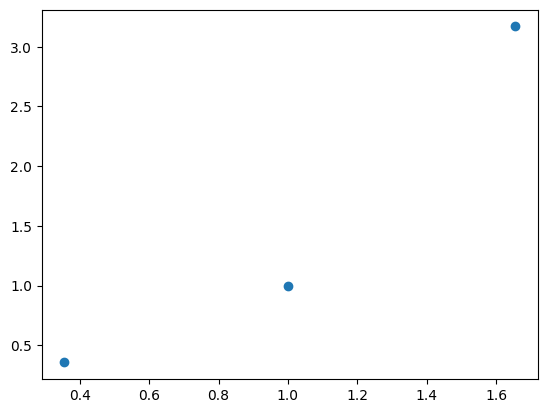

In [47]:
hutch = hutchinson(F, iterate(weighted_random_chooser(FERN2D), 100000))
plt.scatter(hutch[0], hutch[1])
plt.show()

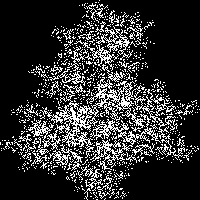

In [8]:
tree_ifs = np.array([[[0.4670822322368622, -0.5178488492965698, 0.02417873963713646],
  [0.5178488492965698, 0.4670822322368622, -0.06665170192718506],
  [0.0, 0.0, 1.0]],
 [[-0.5273969173431396, 0.10378921031951904, 0.03260470926761627],
  [-0.10378921031951904, -0.5273969173431396, 0.18428421020507812],
  [0.0, 0.0, 1.0]],
 [[-0.4779031574726105, 0.33066949248313904, -0.07807090133428574],
  [-0.33066949248313904, -0.4779031574726105, -0.27771109342575073],
  [0.0, 0.0, 1.0]]])
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        determinant_probabilities(FERN2D)[:3]), 
    num_iters=10_000)
render_points(pred_points)


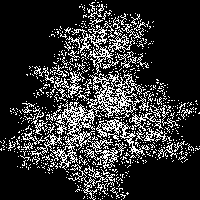

In [9]:
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        determinant_probabilities(tree_ifs)), 
    num_iters=10_000)
render_points(pred_points)

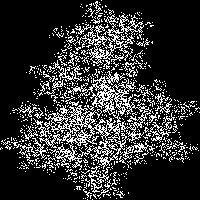

In [12]:
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        np.array([0, 0.9, 0.1])), 
    num_iters=10_000)
render_points(pred_points)

In [76]:
np.average([1, 2], weights=[1.2, -3])

2.6666666666666665